<!--NOTEBOOK_HEADER-->
*This notebook contains course material from [CBE30338](https://jckantor.github.io/CBE30338)
by Jeffrey Kantor (jeff at nd.edu); the content is available [on Github](https://github.com/jckantor/CBE30338.git).
The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<!--NAVIGATION-->
< [Manometer Models and Dynamics](http://nbviewer.jupyter.org/github/jckantor/CBE30338/blob/master/notebooks/03.08-Manometer-Models-and-Dynamics.ipynb) | [Contents](toc.ipynb) | [PID Control](http://nbviewer.jupyter.org/github/jckantor/CBE30338/blob/master/notebooks/04.00-PID_Control.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE30338/blob/master/notebooks/03.09-COVID-19.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE30338/master/notebooks/03.09-COVID-19.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# Modeling the Coronavirus COVID-19 Outbreak

<a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/02.01-Production-Models-with-Linear-Constraints.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>

## The SARS-CoV-2 Coronavirus

The disease now called [COVID-19](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) is caused by the human coronavirus SARS-CoV-2. Human coronaviruses were first identified in the 1960's. There are currently four coronaviruses endemic to human populations around the world:

* 229E (alpha coronavirus)
* NL63 (alpha coronavirus)
* OC43 (beta coronavirus)
* HKU1 (beta coronavirus)

These four common coronaviruses typically cause an upper respiratory disease which, in a minority of cases, progresses to pneumonia. Most people will suffer from at least one of coronaviruses during their lifetimes which cause about a quarter of all common colds.

In recent decades, three coronaviruses that normally infect animals have evolved to infect humans. These include:

* MERS-CoV (the beta coronavirus that causes Middle East Respiratory Syndrome, or MERS)
* SARS-CoV (the beta coronavirus that causes severe acute respiratory syndrome, or SARS)
* SARS-CoV-2 (the novel coronavirus that causes coronavirus disease COVID-19)

The last of these, now called SARS-CoV-2, first appeared in December, 2019, at a seafood market in Wuhan (Hubei, China). The rapid spread of SARS-CoV-2 in Wuhan, and appearance in other locations around the globe, has resulted in the World Health Organization (WHO) declaring a global health emergency. Countries around the globe are mobilizing to track the virus and control new outbreaks. 

At this stage, it is too early to know if these efforts will be successful in preventing COVID-19 from becoming a pandemic, and later an endemic disease with a global footprint. You can find the most recent data on the current outbreak at [Coronavirus COVID-19 Global Cases by Johns Hopkins CSSE](https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).

The purpose of this notebook is to demostrate the modeling of an infectious epidemic using the latest available data for COVID-19. The models and data used in this notebook have been extracted from a rapidly emerging and changing literature.

## References

Keeling, Matt J., and Pejman Rohani. Modeling Infectious Diseases in Humans and Animals. Princeton University Press, 2008. JSTOR, www.jstor.org/stable/j.ctvcm4gk0. Accessed 25 Feb. 2020.

Boldog, Péter, et al. "Risk Assessment of Novel Coronavirus COVID-19 Outbreaks Outside China." Journal of Clinical Medicine 9.2 (2020): 571. https://www.mdpi.com/2077-0383/9/2/571

## Model 1. SIR model for an infectious disease

The SIR model is simple compartment model for an infectious disease that describes key phenomena encountered in epidemiology. In the SIR model, a population is broken into three sub-groups corresponding to stages of the disease:

* **Susceptible.** The subpopulation susceptible to acquire the disease. For SARS-CoV-2, the assumption is that everyone who has not previously acquired the disease is susceptible to infection.
* **Infectious.** The subpopulation that has become infective.
* **Recovered.** The subpopulation that has recovered from infection, and presumed to be no longer susceiptible to the disease.

Neglecting demographic processes of birth and death from other causes, and assuming a negligible death rate due to infectious disease at issue, the progression of an epidemic can be modeled by rate processesl

$$\text{Susceptible}
\xrightarrow{\frac{\beta S I}{N}} 
\text{Infectious} 
\xrightarrow{\gamma I} 
\text{Recovered} $$

The rate processes are modeled as follows.

* $\frac{\beta S I}{N}$ is the rate at which susecptible population encounters the infected population resulting in trasmission of the disease. $S$ is the size of the susceptible population. $\beta$ is a the model parameters with units of 1/day. 
* $\gamma I$ is the rate at which infected population recovers and becomes resistent to further infection. $I$ is the size of the infective population.

A model for the spread of an infectious disease in a uniform population is given by the deterministic SIR equations

\begin{align*}
\frac{dS}{dt} & = -\frac{\beta S I}{N} \\
\frac{dI}{dt} & = \frac{\beta S I}{N} - \gamma I \\
\frac{dR}{dt} & = \gamma I
\end{align*} 

The model becomes more transparent by working with population fractions rather than raw population counts. To this end, define

\begin{align}
s = \frac{S}{N} \qquad
i = \frac{I}{N} \qquad
r = \frac{R}{N}
\end{align} 

After substitution, this results in a system of four equations.

\begin{align*}
\frac{ds}{dt} & = -\beta s i \\
\frac{di}{dt} & = \beta s i - \gamma i \\
\frac{dr}{dt} & = \gamma i
\end{align*} 

where $s + i + r = 1$ is an invariant.

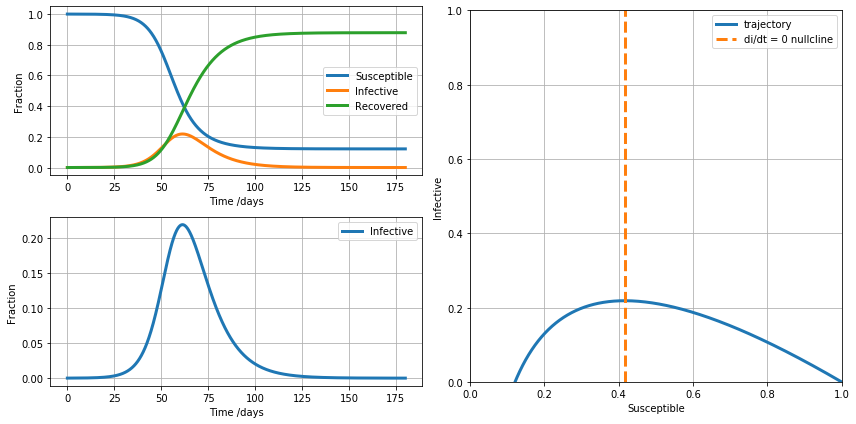

In [0]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# parameter values
R0 = 2.4
t_infective = 5.1 + 3.3

# initial number of infected and recovered individuals
i_initial = 1/20000
r_initial = 0.00
s_initial = 1 - i_initial - r_initial

gamma = 1/t_infective
beta = R0*gamma

# SIR model differential equations.
def deriv(x, t, beta, gamma):
    s, i, r = x
    dsdt = -beta * s * i
    didt = beta * s * i - gamma * i
    drdt =  gamma * i
    return [dsdt, didt, drdt]

t = np.linspace(0, 180, 2000)
x_initial = s_initial, i_initial, r_initial
soln = odeint(deriv, x_initial, t, args=(beta, gamma))
s, i, r = soln.T

# plot the data
fig = plt.figure(figsize=(12,6))
ax = [fig.add_subplot(221, axisbelow=True), 
      fig.add_subplot(223),
      fig.add_subplot(122)]

ax[0].plot(t, s, lw=3, label='Susceptible')
ax[0].plot(t, i, lw=3, label='Infective')
ax[0].plot(t, r, lw=3, label='Recovered')
ax[0].set_xlabel('Time /days')
ax[0].set_ylabel('Fraction')

ax[1].plot(t, i, lw=3, label='Infective')
ax[1].set_xlabel('Time /days')
ax[1].set_ylabel('Fraction')

ax[2].plot(s, i, lw=3, label='trajectory')
ax[2].plot([1/R0, 1/R0], [0, 1], '--', lw=3, label='di/dt = 0 nullcline')
ax[2].set_aspect('equal')
ax[2].set_ylim(0, 1)
ax[2].set_xlim(0, 1)
ax[2].set_xlabel('Susceptible')
ax[2].set_ylabel('Infective')

for a in ax: 
    a.grid(True)
    a.legend()
    
plt.tight_layout()

* The region from $i = 0, s \in [0, \frac{1}{R_0}]$ are all stable attractors. This is the region of **herd immunity**.

* The region from $i=0, s \in (\frac{1}{R_0}, 1]$ are all unstable. Any perturbation with $i > 0$ results in a disease outbreak.

* The size of the outbreak depends on the size of teh suscepitble population. The more susceptibles, the larger the outbeak.

## Model 2. SEIR model

The SEIR model extends the SIR model by adding an additional population compartment containing those individuals who have been exposed to the virus but not yet infective.

* **Exposed.** The subpopulation that has been exposed to the disease but not yet infective. 

The compartment model can be diagrammed as follows.

$$\text{Susceptible}
\xrightarrow{\frac{\beta S I}{N}} 
\text{Exposed} 
\xrightarrow{\alpha E} 
\text{Infectious} 
\xrightarrow{\gamma I} 
\text{Recovered} $$

The rate processes are modeled as follows.

* $\frac{\beta S I}{N}$ is the rate at which susecptible population encounters the infected population resulting in trasmission of the disease. $S$ is the size of the susceptible population. $\beta$ is a the model parameters with units of 1/day. 
* $\alpha E$ is the rate at which exposed population becomes infective, where $E$ is the size of the exposed population. The average period of time in the exposed state is the incubation period of the disease, and equal to $\frac{1}{\alpha}$.
* $\gamma I$ is the rate at which infected population recovers and becomes resistent to further infection. $I$ is the size of the infective population.

An elementary model for the spread of an infectious disease in a uniform population is given by the deterministic SEIR equations}

After substitution, this results in a system of four equations.

\begin{align*}
\frac{ds}{dt} & = -\beta s i \\
\frac{de}{dt} & = \beta s i - \alpha e \\
\frac{di}{dt} & = \alpha e  - \gamma i \\
\frac{dr}{dt} & = \gamma i
\end{align*} 

where $s + e + i + r = 1$ is an invariant.

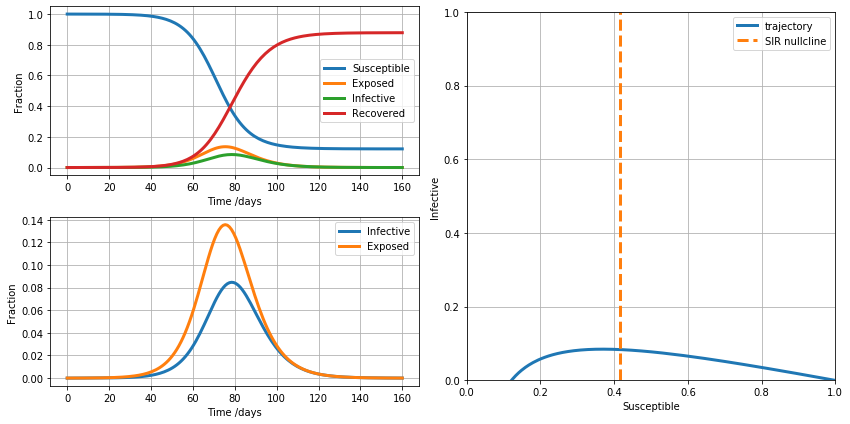

In [0]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# parameter values
R0 = 2.4
t_incubation = 5.1
t_infective = 3.3

# initial number of infected and recovered individuals
e_initial = 1/20000
i_initial = 0.00
r_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial

alpha = 1/t_incubation
gamma = 1/t_infective
beta = R0*gamma

# SEIR model differential equations.
def deriv(x, t, alpha, beta, gamma):
    s, e, i, r = x
    dsdt = -beta * s * i
    dedt =  beta * s * i - alpha * e
    didt = alpha * e - gamma * i
    drdt =  gamma * i
    return [dsdt, dedt, didt, drdt]

t = np.linspace(0, 160, 160)
x_initial = s_initial, e_initial, i_initial, r_initial
soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma))
s, e, i, r = soln.T

# plot the data
fig = plt.figure(figsize=(12,6))
ax = [fig.add_subplot(221, axisbelow=True), 
      fig.add_subplot(223),
      fig.add_subplot(122)]

ax[0].plot(t, s, lw=3, label='Susceptible')
ax[0].plot(t, e, lw=3, label='Exposed')
ax[0].plot(t, i, lw=3, label='Infective')
ax[0].plot(t, r, lw=3, label='Recovered')
ax[0].set_xlabel('Time /days')
ax[0].set_ylabel('Fraction')

ax[1].plot(t, i, lw=3, label='Infective')
ax[1].plot(t, e, lw=3, label='Exposed')
ax[1].set_xlabel('Time /days')
ax[1].set_ylabel('Fraction')

ax[2].plot(s, i, lw=3, label='trajectory')
ax[2].plot([1/R0, 1/R0], [0, 1], '--', lw=3, label='SIR nullcline')
ax[2].set_aspect('equal')
ax[2].set_ylim(0, 1)
ax[2].set_xlim(0, 1)
ax[2].set_xlabel('Susceptible')
ax[2].set_ylabel('Infective')

for a in ax: 
    a.grid(True)
    a.legend()
    
plt.tight_layout()

* The addition of an exposed population compartment slows the outbreak, but doesn't appear to reduce the number of people ultimately infected by the disease.

* What are the campus policy implications of these results?

## Model 3. Mitigation and Social Distancing

* Pan, Jinhua, et al. "Effectiveness of control strategies for Coronavirus Disease 2019: a SEIR dynamic modeling study." medRxiv (2020). https://www.medrxiv.org/content/10.1101/2020.02.19.20025387v3.full.pdf

The lack of a vaccine reduces the options for controlling the COVID-19 outbreak. Current efforts are focused on 'social distancing' designed to reduce transmission of the virus from individuals in the infective state to susceptible individuals.

For the purposes of modeling, we introduce a control parameter $u$ indicating the effectiveness of these efforts. $u=0$ corresponds to no controls, $u=1$ corresponds to perfect isolation of infective individuals. The purpose of this model is to explore how a social distancing stragtegy affects the outcome of an epidemic.

* **Exposed.** The subpopulation that has been exposed to the disease but not yet infective. 

The compartment model can be diagrammed as follows.

$$\text{Susceptible}
\xrightarrow{(1-u)\frac{\beta S I}{N}} 
\text{Exposed} 
\xrightarrow{\alpha E} 
\text{Infectious} 
\xrightarrow{\gamma I} 
\text{Recovered} $$

The rate processes are modeled as follows.

* $(1-u)\frac{\beta S I}{N}$ is the rate at which susecptible population encounters the infected population resulting in trasmission of the disease. $u$ describes the effectiveness on any public health interventions to control transmission of the disease. $u=0$ means no effective public health interventions, $u=1$ means total elimination of disease transmission..

After substitution, this results in a system of four equations.

\begin{align*}
\frac{ds}{dt} & = -(1-u)\beta s i \\
\frac{de}{dt} & = (1-u)\beta s i - \alpha e \\
\frac{di}{dt} & = \alpha e  - \gamma i \\
\frac{dr}{dt} & = \gamma i
\end{align*} 

where $s + e + i + r = 1$ is an invariant.

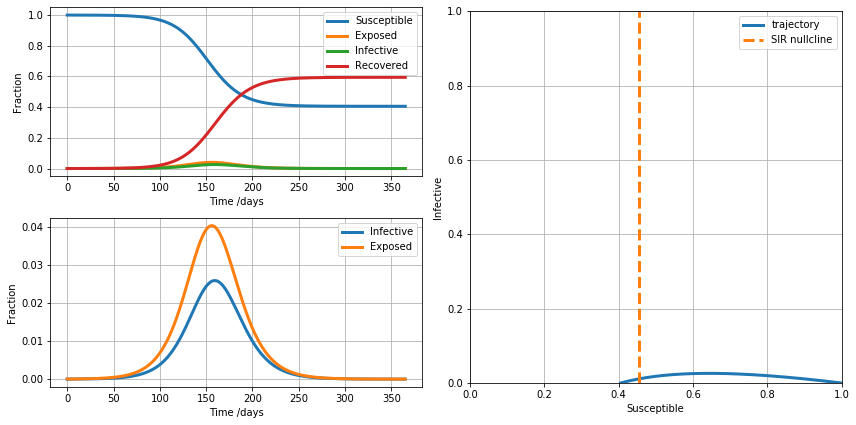

In [0]:
#@title SEIR with Control { run: "auto" }
R0 = 2.2 #@param {type:"slider", min:0.8, max:6, step:0.1}
t_incubation = 5.1 #@param {type:"slider", min:2, max:8, step:0.1}
t_infective = 3.3 #@param {type:"slider", min:1, max:8, step:0.1}
u = 0.31 #@param {type:"slider", min:0, max:1, step:0.01}
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# parameter values

# initial number of infected and recovered individuals
e_initial = 1/20000
i_initial = 0.00
r_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial

alpha = 1/t_incubation
gamma = 1/t_infective
beta = R0*gamma

# SEIR model differential equations.
def deriv(x, t, alpha, beta, gamma):
    s, e, i, r = x
    dsdt = -(1-u)*beta * s * i
    dedt =  (1-u)*beta * s * i - alpha * e
    didt = alpha * e - gamma * i
    drdt =  gamma * i
    return [dsdt, dedt, didt, drdt]

t = np.linspace(0, 365, 365)
x_initial = s_initial, e_initial, i_initial, r_initial
soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma))
s, e, i, r = soln.T

# plot the data
fig = plt.figure(figsize=(12,6))
ax = [fig.add_subplot(221, axisbelow=True), 
      fig.add_subplot(223),
      fig.add_subplot(122)]

ax[0].plot(t, s, lw=3, label='Susceptible')
ax[0].plot(t, e, lw=3, label='Exposed')
ax[0].plot(t, i, lw=3, label='Infective')
ax[0].plot(t, r, lw=3, label='Recovered')
ax[0].set_xlabel('Time /days')
ax[0].set_ylabel('Fraction')

ax[1].plot(t, i, lw=3, label='Infective')
ax[1].plot(t, e, lw=3, label='Exposed')
ax[1].set_xlabel('Time /days')
ax[1].set_ylabel('Fraction')

ax[2].plot(s, i, lw=3, label='trajectory')
ax[2].plot([1/R0, 1/R0], [0, 1], '--', lw=3, label='SIR nullcline')
ax[2].set_aspect('equal')
ax[2].set_ylim(0, 1)
ax[2].set_xlim(0, 1)
ax[2].set_xlabel('Susceptible')
ax[2].set_ylabel('Infective')

for a in ax: 
    a.grid(True)
    a.legend()
    
plt.tight_layout()

Social distancing has several beneficial effects:

* Slows down the progress of the epidemic.
* Seduces the fraction of the population infected at any point in time, thereby reducing strain on health care resources.
* Reduces the number of individuals ultimately experiencing the disease. For a disease with a non-zero mortaility, this saves lives.

## Model 4. Improving the fidelity of the model.

Boldog, et al.

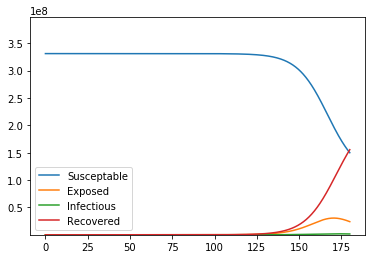

In [0]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

u = 0.3
mu = 0
alpha = 1/5.1   # incubation period
R0 = 2.4
gamma = 3.3
beta = R0*gamma

N = 331000000

def SEIR(x, t):
    S, E1, E2, I1, I2, I3, R = x
    dS = -(1-u)*beta*S*(I1 + I2 + I3)/N
    dE1 = -dS - 2*alpha*E1
    dE2 = 2*alpha*E1 - 2*alpha*E2
    dI1 = 2*alpha*E2 - 3*gamma*I1 - mu*I1
    dI2 = 3*gamma*I1 - 3*gamma*I2 - mu*I2
    dI3 = 3*gamma*I2 - 3*gamma*I3 - mu*I3
    dR = 3*gamma*I3
    return [dS, dE1, dE2, dI1, dI2, dI3, dR]


IC = [N, 1, 0, 0, 0, 0, 0]
t = np.linspace(0, 180, 1000)


soln = odeint(SEIR, IC, t)

S = soln[:, 0]
E = soln[:, 1] + soln[:, 2]
I = soln[:, 3] + soln[:, 4] + soln[:, 5]
R = soln[:, 6]

plt.plot(t, S, label = 'Susceptable')
plt.plot(t, E, label = 'Exposed')
plt.plot(t, I, label = 'Infectious')
plt.plot(t, R, label = 'Recovered')
plt.ylim([1, 1.2*N])

plt.legend()

## Additional Modeling Opportunities. Transportation, power law kinetics, etc.

* Ziff, Robert M., and Anna L. Ziff. "Fractal kinetics of COVID-19 pandemic." medRxiv (2020). https://www.medrxiv.org/content/10.1101/2020.02.16.20023820v1

* Peng, Liangrong, et al. "Epidemic analysis of COVID-19 in China by dynamical modeling." arXiv preprint arXiv:2002.06563 (2020).  https://arxiv.org/abs/2002.06563

* Wu, Joseph T., Kathy Leung, and Gabriel M. Leung. "Nowcasting and forecasting the potential domestic and international spread of the 2019-nCoV outbreak originating in Wuhan, China: a modelling study." The Lancet (2020). https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)30260-9/fulltext

* Tuite, Ashleigh R., and David N. Fisman. "Reporting, Epidemic Growth, and Reproduction Numbers for the 2019 Novel Coronavirus (2019-nCoV) Epidemic." Annals of Internal Medicine (2020). https://annals.org/aim/fullarticle/2760912

<!--NAVIGATION-->
< [Manometer Models and Dynamics](http://nbviewer.jupyter.org/github/jckantor/CBE30338/blob/master/notebooks/03.08-Manometer-Models-and-Dynamics.ipynb) | [Contents](toc.ipynb) | [PID Control](http://nbviewer.jupyter.org/github/jckantor/CBE30338/blob/master/notebooks/04.00-PID_Control.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE30338/blob/master/notebooks/03.09-COVID-19.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE30338/master/notebooks/03.09-COVID-19.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>